In [1]:
import os
import numpy as np, pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def save_plot_and_show(name, dir_path="plots"):
    """Сохраняет активную фигуру"""
    os.makedirs(dir_path, exist_ok=True)
    filepath = os.path.join(dir_path, f"{name}.png")
    plt.savefig(filepath, dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()
plt.rcParams.update({
    'font.size': 14,           # Размер основного шрифта
    'axes.titlesize': 16,      # Размер заголовков осей
    'axes.labelsize': 16,      # Размер подписей осей
    'xtick.labelsize': 14,     # Размер подписей по оси X
    'ytick.labelsize': 14,     # Размер подписей по оси Y
    'legend.fontsize': 12,     # Размер шрифта легенды
})

In [3]:
train = pd.read_csv(f"data/train.csv")
test  = pd.read_csv(f"data/test.csv")
target = "delay_minutes"

In [4]:
def add_time_feats(df):
    x = 2*np.pi*(df["planned_arrival_min"]/1440.0)
    df = df.copy()
    df["time_sin"], df["time_cos"] = np.sin(x), np.cos(x)
    df["hour"] = (df["planned_arrival_min"]//60 % 24).astype(int)
    return df

train = add_time_feats(train)
test  = add_time_feats(test)

In [5]:
y = train[target].clip(lower=0)
num = ["stop_sequence","planned_arrival_min","distance_run_km","headway_min","temp_c","precip_mm","wind_mps",
            "traffic_index","time_sin","time_cos","hour"]
cat = ["route_id","weekday","is_holiday"]
X = train[num+cat]
X_test = test[num+cat]
groups = train["trip_id"]
X.head(n=3)

,stop_sequence,planned_arrival_min,distance_run_km,headway_min,temp_c,precip_mm,wind_mps,traffic_index,time_sin,time_cos,hour,route_id,weekday,is_holiday
0,0,302.00,0.000,19.45,9.51,0.0,0.3,2.9,0.968148,0.250380,5,R00,0,0
1,1,303.88,0.443,19.45,9.51,0.0,0.3,2.9,0.970169,0.242430,5,R00,0,0
2,2,307.68,1.489,19.45,9.51,0.0,0.3,2.9,0.974055,0.226311,5,R00,0,0


In [11]:
def validate_model(params):
    pre = ColumnTransformer([
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat)
    ], remainder="passthrough")
    
    model = Pipeline([
        ("pre", pre),
        ("rf", HistGradientBoostingRegressor(**params, random_state=42))
    ])
    
    cv = GroupKFold(n_splits=5)
    oof = np.zeros(len(X))
    for fold, (tr, va) in enumerate(cv.split(X, y, groups=groups), 1):
        model.fit(X.iloc[tr], y.iloc[tr])
        oof[va] = model.predict(X.iloc[va])
        rmse = root_mean_squared_error(y.iloc[va], oof[va])
        print(f"Fold {fold} RMSE: {rmse:.4f}")
    print("CV RMSE:", root_mean_squared_error(y, oof))
    print(f"params: {params}")

In [12]:
validate_model({})

Fold 1 RMSE: 1.4543
Fold 2 RMSE: 1.4727
Fold 3 RMSE: 1.4627
Fold 4 RMSE: 1.4557
Fold 5 RMSE: 1.4594
CV RMSE: 1.460981896278909
params: {}


In [27]:
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.ensemble import HistGradientBoostingRegressor

# распределение параметров
param_distributions = {
    'max_depth': [2, 3, 5, 7],
    'learning_rate': np.arange(0.05, 0.16, 0.01),
    'max_iter': [100, 150, 200, 300],
    'min_samples_leaf': [10, 20, 30, 40],
    'l2_regularization': [0.0, 0.1, 0.5, 1.0]
}

# создание и обучение модели
random_search = RandomizedSearchCV(
    estimator=HistGradientBoostingRegressor(random_state=42, categorical_features=cat),
    param_distributions=param_distributions,
    n_iter=30,
    cv=GroupKFold(n_splits=5),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X, y, groups=groups)
best_params = random_search.best_params_

In [28]:
validate_model(best_params)

Fold 1 RMSE: 1.4534
Fold 2 RMSE: 1.4700
Fold 3 RMSE: 1.4584
Fold 4 RMSE: 1.4538
Fold 5 RMSE: 1.4582
CV RMSE: 1.4587649813649284
params: {'min_samples_leaf': 30, 'max_iter': 300, 'max_depth': 2, 'learning_rate': np.float64(0.07), 'l2_regularization': 1.0}


In [21]:
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# Определение пространства параметров для ПОЛНОГО перебора
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'learning_rate': [0.07, 0.1, 0.13],
    'max_iter': [100, 200, 300],
    'min_samples_leaf': [10, 20, 40],
    'l2_regularization': [0.0, 0.1, 0.5, 1]
}

# Создание модели поиска по сетке (GridSearchCV)
grid_search = GridSearchCV(
    estimator=HistGradientBoostingRegressor(random_state=42, categorical_features=cat),
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),  # Групповая кросс-валидация
    scoring='neg_root_mean_squared_error',  # Используем отрицательное RMSE
    n_jobs=-1,  # Использовать все ядра процессора
    refit=True  # Автоматически обучить лучшую модель на всех данных после поиска
)

# Обучение модели поиска (это может занять время!)
print("Начинается поиск по сетке...")
print(f"Всего комбинаций: {len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['max_iter']) * len(param_grid['min_samples_leaf']) * len(param_grid['l2_regularization'])}")
print("-" * 50)

grid_search.fit(X, y, groups=groups)

best_params = grid_search.best_params_

Начинается поиск по сетке...
Всего комбинаций: 540
--------------------------------------------------


In [22]:
validate_model(best_params)

Fold 1 RMSE: 1.4535
Fold 2 RMSE: 1.4708
Fold 3 RMSE: 1.4586
Fold 4 RMSE: 1.4537
Fold 5 RMSE: 1.4580
CV RMSE: 1.4589214048287222
params: {'l2_regularization': 0.0, 'learning_rate': 0.07, 'max_depth': 3, 'max_iter': 200, 'min_samples_leaf': 40}


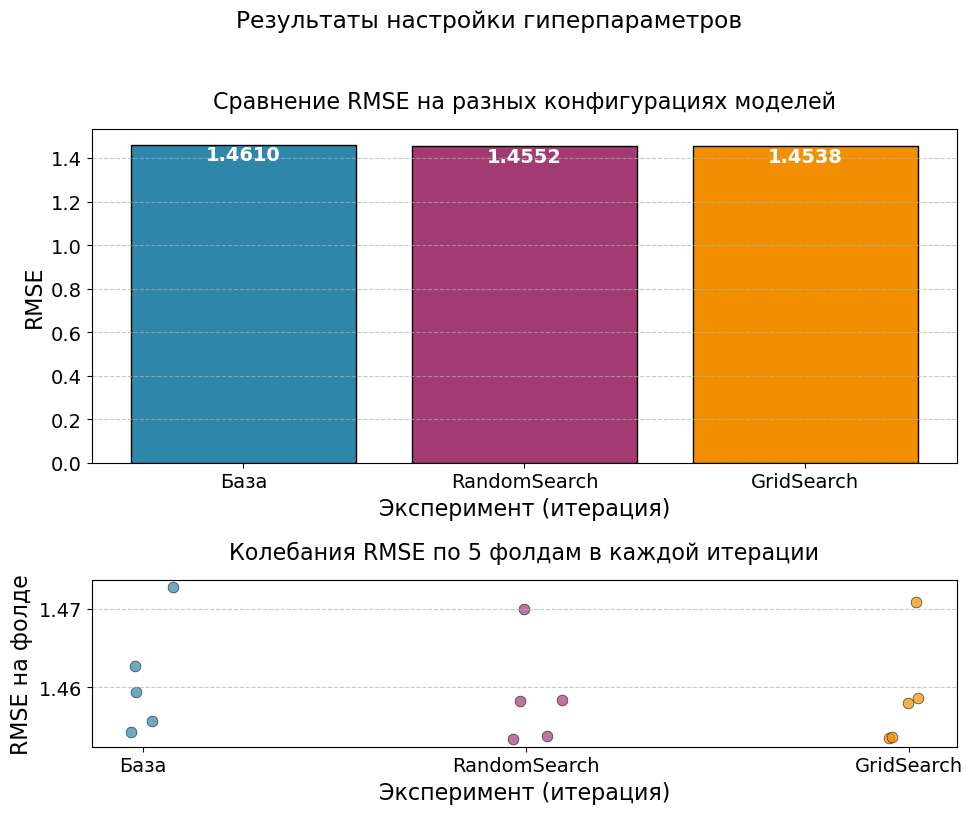

In [31]:
iterations = ['База', 'RandomSearch', 'GridSearch']
avg_rmse = [1.4610, 1.4552, 1.4538]  # Итоговый средний RMSE для каждой итерации

# Примерные данные по 5 фолдам для каждой итерации (ЗАМЕНИТЕ на ваши реальные значения!)
fold_data = {
    'База': [1.4543, 1.4727, 1.4627, 1.4557, 1.4594],  # RMSE по 5 фолдам для Базовой модели
    'RandomSearch': [1.4534, 1.4700, 1.4584, 1.4538, 1.4582],
    'GridSearch': [1.4535, 1.4708, 1.4586, 1.4537, 1.4580]
}

# 1. Создаём фигуру с двумя subplot: барчарт и точечная диаграмма
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[2, 1])

# 2. БАРЧАРТ: Средний RMSE по итерациям
x_pos = np.arange(len(iterations))
bars = ax1.bar(x_pos, avg_rmse, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'], edgecolor='black')

# Настройки первого графика
ax1.set_title('Сравнение RMSE на разных конфигурациях моделей', pad=15)
ax1.set_xlabel('Эксперимент (итерация)')
ax1.set_ylabel('RMSE')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(iterations, rotation=0)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Добавляем значения на столбцы
for bar, value in zip(bars, avg_rmse):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height - 0.003,
            f'{value:.4f}', ha='center', va='top', color='white', fontweight='bold')

# 3. ТОЧЕЧНАЯ ДИАГРАММА: Колебания по фолдам
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
for i, (iter_name, fold_values) in enumerate(fold_data.items()):
    # Разбрасываем точки по горизонтали для наглядности
    x_jittered = np.random.normal(i, 0.05, size=len(fold_values))
    ax2.scatter(x_jittered, fold_values, alpha=0.7, color=colors[i], s=60, label=iter_name, edgecolors='black', linewidth=0.5)

# Настройки второго графика
ax2.set_title('Колебания RMSE по 5 фолдам в каждой итерации', pad=15)
ax2.set_xlabel('Эксперимент (итерация)')
ax2.set_ylabel('RMSE на фолде')
ax2.set_xticks(range(len(iterations)))
ax2.set_xticklabels(iterations, rotation=0)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Общие настройки
plt.suptitle('Результаты настройки гиперпараметров', y=1.02)
plt.tight_layout()

# 5. Сохраняем график
save_plot_and_show('params_searching')